# Lie Detection: Reliability of Relevant Predictors in Classifiers

[INTRODUCTION OF THE PROBLEM HERE]

### Datasets:
[ADD AND COMMENT ABOUT DATASETS HERE]
### Tasks:
[ADD TASK HERE]

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Phillippe Robert, 2041505, philippe.robert@studenti.unipd.it
- Huzaifa Fazal,

## Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Load datasets

In [4]:
BF_CTU_df = pd.read_csv("data/BF_df_CTU.csv", delimiter=",")
BF_OU_df = pd.read_csv("data/BF_df_OU.csv", delimiter=",")
BF_V_df = pd.read_csv("data/BF_df_V.csv", delimiter=",")
DT_CC_df = pd.read_csv("data/DT_df_CC.csv", delimiter=",")
DT_JI_df = pd.read_csv("data/DT_df_JI.csv", delimiter=";")
IADQ_df = pd.read_csv("data/IADQ_df.csv", delimiter=",")
IESR_df = pd.read_csv("data/IESR_df.csv", delimiter=",")
NAQR_df = pd.read_csv("data/NAQ_R_df.csv", delimiter=";")
PCL5_df = pd.read_csv("data/PCL5_df.csv", delimiter=";")
PHQ9_df = pd.read_csv("data/PHQ9_GAD7_df.csv", delimiter=";")
PID5_df = pd.read_csv("data/PID5_df.csv", delimiter=";")
PRFQ_df = pd.read_csv("data/PRFQ_df.csv", delimiter=",")
PRMQ_df = pd.read_csv("data/PRMQ_df.csv", delimiter=",")
DDDT_df = pd.read_csv("data/RAW_DDDT.CSV", delimiter=",")
SPID5_df = pd.read_csv("data/sPID-5_df.csv", delimiter=",")
RNEOPI_honest_df = pd.read_excel("data/Honest.xlsx", header=1)
RNEOPI_fake_df = pd.read_excel("data/Faked.xlsx", header=1)

## Baseline Feature Importance

In [17]:
def evaluate_clf(df, clf, cv):
    """
    Performs cross-validation of a classifier over a dataset
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]
    """
    
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1', return_estimator=True)
    
    return output

In [18]:
def get_feature_importance(model_output):
    """
    Averages feature importances / coefficient values from all the fitted estimators
    
    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns: (dict) {predictor: value}
    """
    
    n_folds = len(output["estimator"])
    n_features = output["estimator"][0].n_features_in_

    coeficients = np.zeros(n_features)
    for estimator in output["estimator"]:
        if isinstance(estimator, LogisticRegression):
            coeficients += estimator.coef_[0] # TODO: RF uses feature_importances insted of coef_
        else:
            coeficients += estimator.feature_importances_[0]
    coeficients = coeficients/n_folds
    res = dict(zip(estimator.feature_names_in_, coeficients))

    return res

In [19]:
def plot_feature_importance(feature_importance, title):
    """
    Plots a bar chart of the importance/coefficients of the predictors
    
    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart
    """
    
    plt.bar(x=feature_importance.keys(), height=feature_importance.values())
    plt.title(title)
    plt.xlabel("Feature Name")
    plt.ylabel("Importance Score")
    plt.show()

### Logistic Regression

Cross-Validated F1-Score: 0.8226637026072661


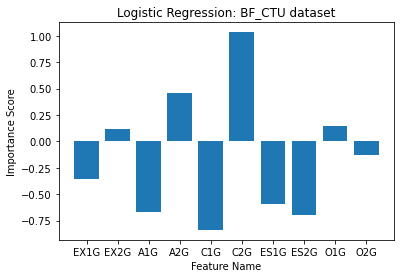

In [21]:
clf = LogisticRegression(solver="lbfgs")
output = evaluate_clf(BF_CTU_df, clf, cv=5)

f1_score = np.mean(output["test_score"])
feature_importance = get_feature_importance(output)

print(f"Cross-Validated F1-Score: {f1_score}")
plot_feature_importance(feature_importance, title="Logistic Regression: BF_CTU dataset")

### Random Forest

Cross-Validated Accuracy: 0.8417517875383045


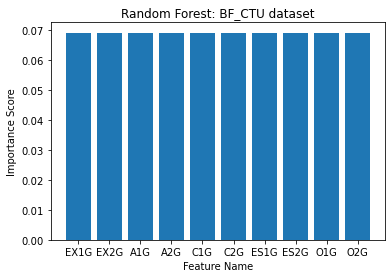

In [30]:
clf = RandomForestClassifier(n_estimators=300, random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)

accuracy = np.mean(output["test_score"])
feature_importance = get_feature_importance(output)

print(f"Cross-Validated Accuracy: {accuracy}")
plot_feature_importance(feature_importance, title="Random Forest: BF_CTU dataset")

### SVM

In [1]:
# TODO: fit a SVM classifier get f1-score and plot feature importances

### XGBoost

In [2]:
# TODO: fit a XGBoost classifier get f1-score and plot feature importances